In [1]:
import pandas as pd

df1 = pd.read_csv('positive.csv', na_values=['NULL'])

df2 = pd.read_csv('negative.csv', na_values=['NULL'])

df = pd.concat([df1, df2], ignore_index=True)

df['AcquisitionDateTime_DT'] = pd.to_datetime(df['AcquisitionDateTime_DT'])

print(df.head())

print(df.info())
print(df.isnull().sum())

  PatientID                              12SL_Codes Source  \
0   HR00008       22,542,1665,533,1666,780,831,1699  PTBXL   
1   HR00077                         22,964,821,1699  PTBXL   
2   HR00085  22,542,1665,531,1666,1682,740,831,1699  PTBXL   
3   HR00103                     23,470,780,831,1699  PTBXL   
4   HR00128                    22,1682,780,831,1699  PTBXL   

                                          Phys_Codes  MI_12SL  MI_Phys  \
0          164865005, 164951009, 39732003, 426783006        1        1   
1                     426783006, 54329005, 713426002        1        1   
2                                          426783006        1        0   
3  164865005, 164951009, 39732003, 427084000, 445...        1        1   
4                                          164934002        1        0   

   TestID  PatientAge  Gender AcquisitionDateTime_DT  ...  STDOWN_V6  \
0       8         NaN     NaN    2020-04-23 07:59:54  ...          0   
1      77         NaN     NaN    2020-

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

y = df["MI_Phys"]

analysis_codes_fn = ['HR00039', 'HR00162', 'HR00274', 'HR00282', 'HR00308']
analysis_codes_fp = ['HR00085', 'HR00128', 'HR00222', 'HR00265', 'HR00527', 'HR00529', 'HR00855', 'HR00994', 'HR00995', 'HR01026', 'HR01528', 'HR02158', 'HR04251', 'HR04274', 'HR04841', 'HR04986', 'HR04986', 'HR05233', 'HR06205', 'HR08265', 'HR10943', 'HR11886', 'JS00403', 'Q0012', 'Q0016']

df_fn_records = df[df['PatientID'].isin(analysis_codes_fn)]
df_fp_records = df[df['PatientID'].isin(analysis_codes_fp)]

df_fn_records_clean = df_fn_records.drop(columns=["12SL_Codes", "MI_12SL","Phys_Codes", "TestID", "Source",
                                                  "Gender", "PatientAge", "AcquisitionDateTime_DT", "MI_Phys", "POffset", "PAxis", "POnset"])
df_fp_records_clean = df_fp_records.drop(columns=["12SL_Codes", "MI_12SL","Phys_Codes", "TestID", "Source",
                                                  "Gender", "PatientAge", "AcquisitionDateTime_DT", "MI_Phys", "POffset", "PAxis", "POnset"])

X = df.drop(columns=["PatientID", "12SL_Codes", "Phys_Codes", "TestID", "Source", 
                     "Gender", "PatientAge", "AcquisitionDateTime_DT", "MI_Phys", "POffset", "PAxis", "POnset"])

#drop columns that include "P_", "Full", "Rate"

X = X.loc[:, ~X.columns.str.contains('^P_')]
X = X.loc[:, ~X.columns.str.contains('^PP_')]
X = X.loc[:, ~X.columns.str.contains('PFull')]
X = X.loc[:, ~X.columns.str.contains('Rate')]

#reverse to get list or removed columns
removed_columns = df.columns[~df.columns.isin(X.columns)].tolist()
print("Removed columns: ", removed_columns)

df_fn_records_clean = df_fn_records_clean.loc[:, ~df_fn_records_clean.columns.str.contains('^P_')]
df_fn_records_clean = df_fn_records_clean.loc[:, ~df_fn_records_clean.columns.str.contains('^PP_')]
df_fn_records_clean = df_fn_records_clean.loc[:, ~df_fn_records_clean.columns.str.contains('PFull')]
df_fn_records_clean = df_fn_records_clean.loc[:, ~df_fn_records_clean.columns.str.contains('Rate')]

df_fp_records_clean = df_fp_records_clean.loc[:, ~df_fp_records_clean.columns.str.contains('^P_')]
df_fp_records_clean = df_fp_records_clean.loc[:, ~df_fp_records_clean.columns.str.contains('^PP_')]
df_fp_records_clean = df_fp_records_clean.loc[:, ~df_fp_records_clean.columns.str.contains('PFull')]
df_fp_records_clean = df_fp_records_clean.loc[:, ~df_fp_records_clean.columns.str.contains('Rate')]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Save the original algorithm's prediction for test set before dropping it
y_12SL = X_test["MI_12SL"]

# Split data based on MI_12SL classification
X_train_pos = X_train[X_train["MI_12SL"] == 1].drop(columns=["MI_12SL"])
X_train_neg = X_train[X_train["MI_12SL"] == 0].drop(columns=["MI_12SL"])
X_test_pos = X_test[X_test["MI_12SL"] == 1].drop(columns=["MI_12SL"])
X_test_neg = X_test[X_test["MI_12SL"] == 0].drop(columns=["MI_12SL"])

# Ensure y labels match the correct samples
y_train_pos = y_train.loc[X_train_pos.index]  # True positives or false positives
y_train_neg = y_train.loc[X_train_neg.index]  # True negatives or false negatives
y_test_pos = y_test.loc[X_test_pos.index]
y_test_neg = y_test.loc[X_test_neg.index]

X_train = X_train.drop(columns=["MI_12SL"])
X_test = X_test.drop(columns=["MI_12SL"])

# Extract MI_12SL predictions
y_12SL_pos = y_12SL.loc[X_test_pos.index]  # Original classifier's labels
y_12SL_neg = y_12SL.loc[X_test_neg.index]


Removed columns:  ['PatientID', '12SL_Codes', 'Source', 'Phys_Codes', 'MI_Phys', 'TestID', 'PatientAge', 'Gender', 'AcquisitionDateTime_DT', 'VentricularRate', 'AtrialRate', 'P_RInterval', 'POnset', 'POffset', 'PAxis', 'P_OnsetAmpl_I', 'P_PeakAmpl_I', 'P_Duration_I', 'P_Area_I', 'P_PeakTime_I', 'PP_PeakAmpl_I', 'PP_Duration_I', 'PP_Area_I', 'PP_PeakTime_I', 'PFull_Area_I', 'P_OnsetAmpl_II', 'P_PeakAmpl_II', 'P_Duration_II', 'P_Area_II', 'P_PeakTime_II', 'PP_PeakAmpl_II', 'PP_Duration_II', 'PP_Area_II', 'PP_PeakTime_II', 'PFull_Area_II', 'P_OnsetAmpl_III', 'P_PeakAmpl_III', 'P_Duration_III', 'P_Area_III', 'P_PeakTime_III', 'PP_PeakAmpl_III', 'PP_Duration_III', 'PP_Area_III', 'PP_PeakTime_III', 'PFull_Area_III', 'P_OnsetAmpl_AVR', 'P_PeakAmpl_AVR', 'P_Duration_AVR', 'P_Area_AVR', 'P_PeakTime_AVR', 'PP_PeakAmpl_AVR', 'PP_Duration_AVR', 'PP_Area_AVR', 'PP_PeakTime_AVR', 'PFull_Area_AVR', 'P_OnsetAmpl_AVL', 'P_PeakAmpl_AVL', 'P_Duration_AVL', 'P_Area_AVL', 'P_PeakTime_AVL', 'PP_PeakAmpl_AVL

Positive Samples Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1108
           1       0.78      0.65      0.71       793

    accuracy                           0.78      1901
   macro avg       0.78      0.76      0.76      1901
weighted avg       0.78      0.78      0.77      1901

Positive Samples Confusion Matrix:
[[960 148]
 [279 514]]
Positive Samples Accuracy: 0.7753813782219884
Positive Samples ROC AUC: 0.8464440660836471


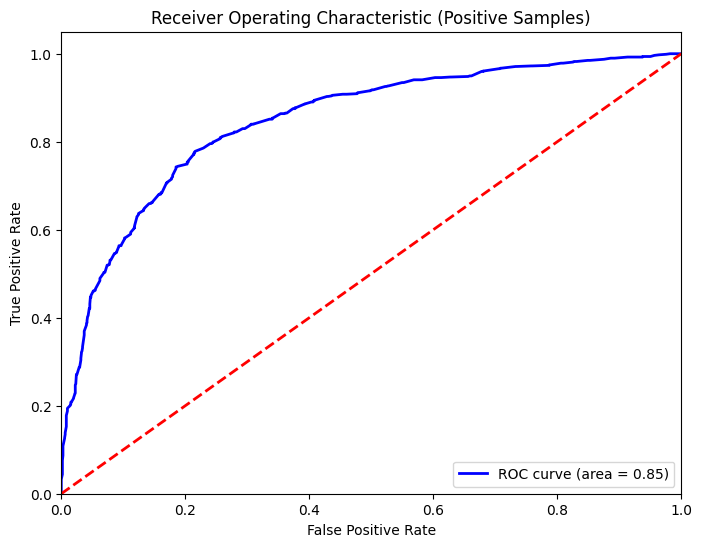

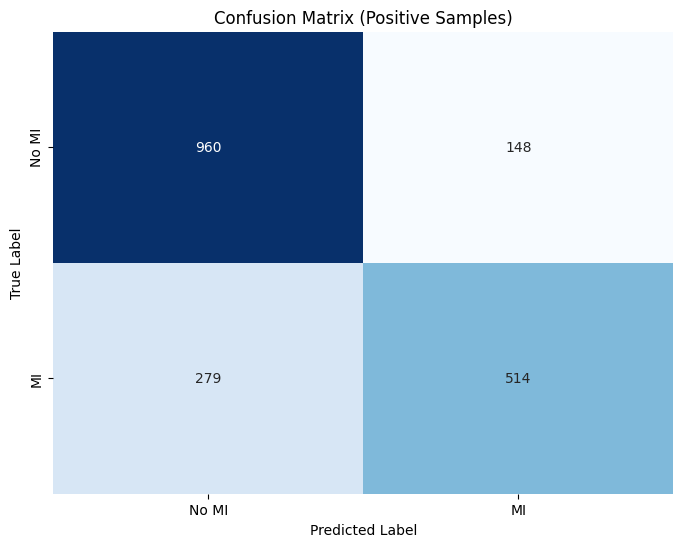

In [3]:
#train random forest classifer model on the positive samples
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay


# Train Random Forest Classifier on positive samples
rf_pos = RandomForestClassifier(random_state=42)
rf_pos.fit(X_train_pos, y_train_pos)
y_pred_pos = rf_pos.predict(X_test_pos)
y_pred_proba_pos = rf_pos.predict_proba(X_test_pos)[:, 1]

# Evaluate the model on positive samples
print("Positive Samples Classification Report:")
print(classification_report(y_test_pos, y_pred_pos))
print("Positive Samples Confusion Matrix:")
print(confusion_matrix(y_test_pos, y_pred_pos))
print("Positive Samples Accuracy:", accuracy_score(y_test_pos, y_pred_pos))
print("Positive Samples ROC AUC:", auc(*roc_curve(y_test_pos, y_pred_proba_pos)[:2]))

# Plot ROC curve for positive samples
fpr_pos, tpr_pos, _ = roc_curve(y_test_pos, y_pred_proba_pos)
roc_auc_pos = auc(fpr_pos, tpr_pos)
plt.figure(figsize=(8, 6))
plt.plot(fpr_pos, tpr_pos, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_pos))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Positive Samples)')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix for positive samples
cm_pos = confusion_matrix(y_test_pos, y_pred_pos)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pos, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No MI', 'MI'], yticklabels=['No MI', 'MI'])
plt.title('Confusion Matrix (Positive Samples)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



Positive Samples Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.09      0.17     12762
           1       0.06      1.00      0.12       801

    accuracy                           0.14     13563
   macro avg       0.53      0.54      0.14     13563
weighted avg       0.94      0.14      0.16     13563

Positive Samples Confusion Matrix:
[[ 1157 11605]
 [    1   800]]
Positive Samples Accuracy: 0.14428961144289612
Positive Samples ROC AUC: 0.8431304819766703


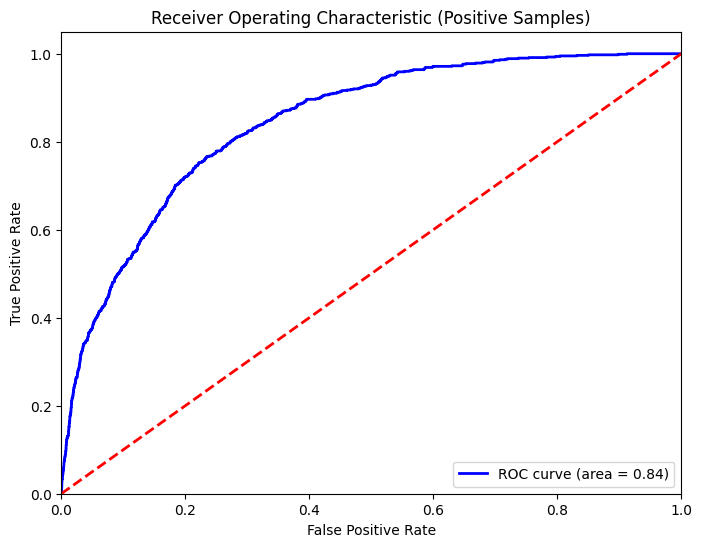

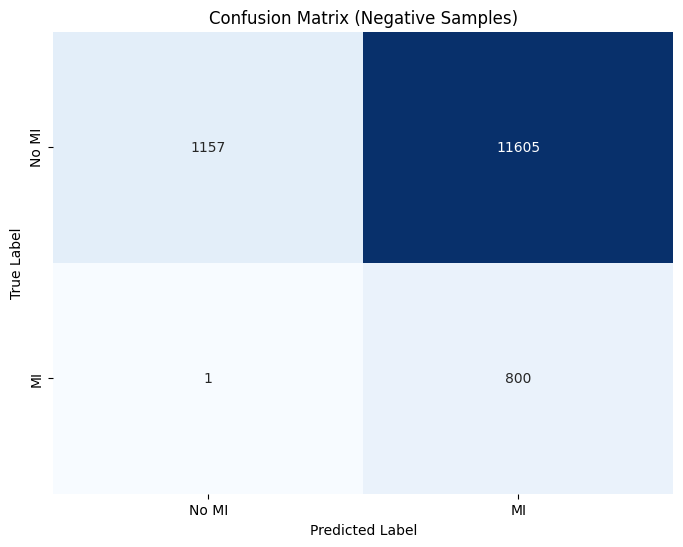

In [4]:
#train random forest classifer model on the negative samples
# Train Random Forest Classifier on negative samples
rf_neg = RandomForestClassifier(random_state=42, class_weight={0: 0.25, 1: 100}, max_depth=5)  # Adjust class weights for imbalanced data
rf_neg.fit(X_train_neg, y_train_neg)
y_pred_neg = rf_neg.predict(X_test_neg)
y_pred_proba_neg = rf_neg.predict_proba(X_test_neg)[:, 1]

# Evaluate the model on negative samples
print("Positive Samples Classification Report:")
print(classification_report(y_test_neg, y_pred_neg))
print("Positive Samples Confusion Matrix:")
print(confusion_matrix(y_test_neg, y_pred_neg))
print("Positive Samples Accuracy:", accuracy_score(y_test_neg, y_pred_neg))
print("Positive Samples ROC AUC:", auc(*roc_curve(y_test_neg, y_pred_proba_neg)[:2]))

# Plot ROC curve for negative samples
fpr_neg, tpr_neg, _ = roc_curve(y_test_neg, y_pred_proba_neg)
roc_auc_neg = auc(fpr_neg, tpr_neg)
plt.figure(figsize=(8, 6))
plt.plot(fpr_neg, tpr_neg, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_neg))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Positive Samples)')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix for negative samples
cm_neg = confusion_matrix(y_test_neg, y_pred_neg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_neg, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No MI', 'MI'], yticklabels=['No MI', 'MI'])
plt.title('Confusion Matrix (Negative Samples)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [5]:
#hyper parameter tuning using hyperopt for the negative samples for all hyperparasameters
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import roc_auc_score

# Define the objective function for hyperopt
def objective(params):
    # Create a Random Forest Classifier with the given hyperparameters
    rf = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        max_features=params['max_features'],
        class_weight=params['class_weight'], 
        criterion=params['criterion'],
        #bootstrap=params['bootstrap'],
        oob_score=params['oob_score'],
        warm_start=params['warm_start'],
        max_samples=params['max_samples'],
        ccp_alpha=params['ccp_alpha'],
        max_leaf_nodes=int(params['max_leaf_nodes']),
        min_impurity_decrease=params['min_impurity_decrease'],
        min_weight_fraction_leaf=params['min_weight_fraction_leaf'],
        n_jobs=params['n_jobs'],
        random_state=42
    )
    
    # Perform cross-validation and return the mean accuracy
    score = cross_val_score(rf, X_train_neg, y_train_neg, cv=5, scoring='f1_weighted').mean()
    
    return {'loss': 1-score, 'status': STATUS_OK}

# Define the search space for hyperparameters
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    'class_weight': hp.choice('class_weight', [{0:1, 1:20}, {0: 0.25, 1: 1000}, {0: 1, 1: 1}]),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    #'bootstrap': hp.choice('bootstrap', [True, False]),
    'oob_score': hp.choice('oob_score', [True, False]),
    'warm_start': hp.choice('warm_start', [True, False]),
    'max_samples': hp.quniform('max_samples', 0.1, 1.0, 0.1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 0.1, 0.01),
    'max_leaf_nodes': hp.quniform('max_leaf_nodes', 5, 50, 1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 0.1, 0.01),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.01),
    'n_jobs': hp.choice('n_jobs', [-1]),
}

# Create a Trials object to store the results
trials = Trials()
# Run hyperopt to find the best hyperparameters
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Number of evaluations
    trials=trials
)
print("Best hyperparameters: ", best)

100%|██████████| 50/50 [23:57<00:00, 28.74s/trial, best loss: 0.0865597336693309]
Best hyperparameters:  {'ccp_alpha': np.float64(0.1), 'class_weight': np.int64(2), 'criterion': np.int64(1), 'max_depth': np.float64(19.0), 'max_features': np.int64(1), 'max_leaf_nodes': np.float64(28.0), 'max_samples': np.float64(0.7000000000000001), 'min_impurity_decrease': np.float64(0.08), 'min_samples_leaf': np.float64(4.0), 'min_samples_split': np.float64(19.0), 'min_weight_fraction_leaf': np.float64(0.3), 'n_estimators': np.float64(110.0), 'n_jobs': np.int64(0), 'oob_score': np.int64(0), 'warm_start': np.int64(0)}


Best Hyperparameters Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     12762
           1       0.00      0.00      0.00       801

    accuracy                           0.94     13563
   macro avg       0.47      0.50      0.48     13563
weighted avg       0.89      0.94      0.91     13563

Best Hyperparameters Confusion Matrix:
[[12762     0]
 [  801     0]]
Best Hyperparameters Accuracy: 0.9409422694094227
Best Hyperparameters ROC AUC: 0.7927394862361556


c:\Users\Sam\Downloads\StrokeOfLuck\stroke-of-luck\ebm_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sam\Downloads\StrokeOfLuck\stroke-of-luck\ebm_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sam\Downloads\StrokeOfLuck\stroke-of-luck\ebm_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

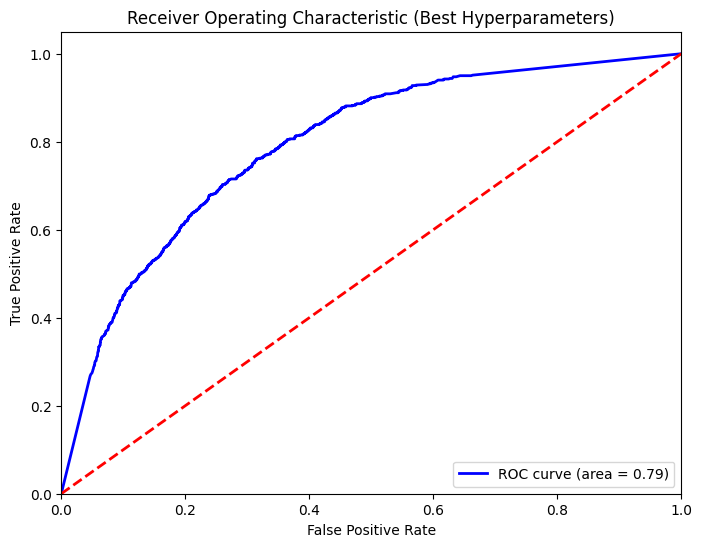

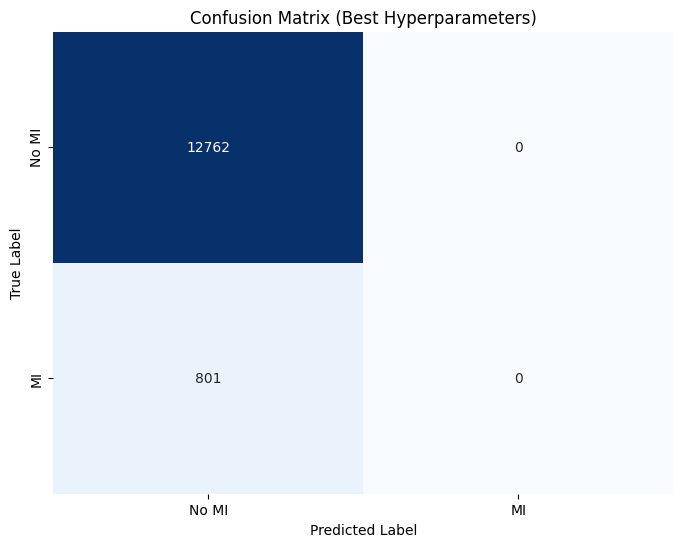

In [6]:
# run the model with the best hyperparameters

best_params = {
    # 'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'min_samples_split': int(best['min_samples_split']),
    'min_samples_leaf': int(best['min_samples_leaf']),
    'max_features': ['sqrt', 'log2'][best['max_features']],
    'class_weight': [{0:1, 1:20}, {0: 0.25, 1: 1000}, {0: 10, 1: 100}][best['class_weight']],
    'criterion': ['gini', 'entropy'][best['criterion']],
    #'bootstrap': [True, False][best['bootstrap']],
    'oob_score': [True, False][best['oob_score']],
    'warm_start': [True, False][best['warm_start']],
    'max_samples': best['max_samples'],
    'ccp_alpha': best['ccp_alpha'],
    'max_leaf_nodes': int(best['max_leaf_nodes']),
    'min_impurity_decrease': best['min_impurity_decrease'],
    'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
    'n_jobs': [-1][best['n_jobs']],
}
# Create a Random Forest Classifier with the best hyperparameters
rf_best = RandomForestClassifier(**best_params, random_state=42, n_estimators=1000)
rf_best.fit(X_train_neg, y_train_neg)
y_pred_best = rf_best.predict(X_test_neg)
y_pred_proba_best = rf_best.predict_proba(X_test_neg)[:, 1]

# Evaluate the model with the best hyperparameters
print("Best Hyperparameters Classification Report:")
print(classification_report(y_test_neg, y_pred_best))
print("Best Hyperparameters Confusion Matrix:")
print(confusion_matrix(y_test_neg, y_pred_best))
print("Best Hyperparameters Accuracy:", accuracy_score(y_test_neg, y_pred_best))
print("Best Hyperparameters ROC AUC:", auc(*roc_curve(y_test_neg, y_pred_proba_best)[:2]))

# Plot ROC curve for best hyperparameters
fpr_best, tpr_best, _ = roc_curve(y_test_neg, y_pred_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_best))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Best Hyperparameters)')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix for best hyperparameters
cm_best = confusion_matrix(y_test_neg, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No MI', 'MI'], yticklabels=['No MI', 'MI'])
plt.title('Confusion Matrix (Best Hyperparameters)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# # Save the model
# import joblib
# joblib.dump(rf_best, 'rf_model.pkl')

# # Load the model
# rf_loaded = joblib.load('rf_model.pkl')


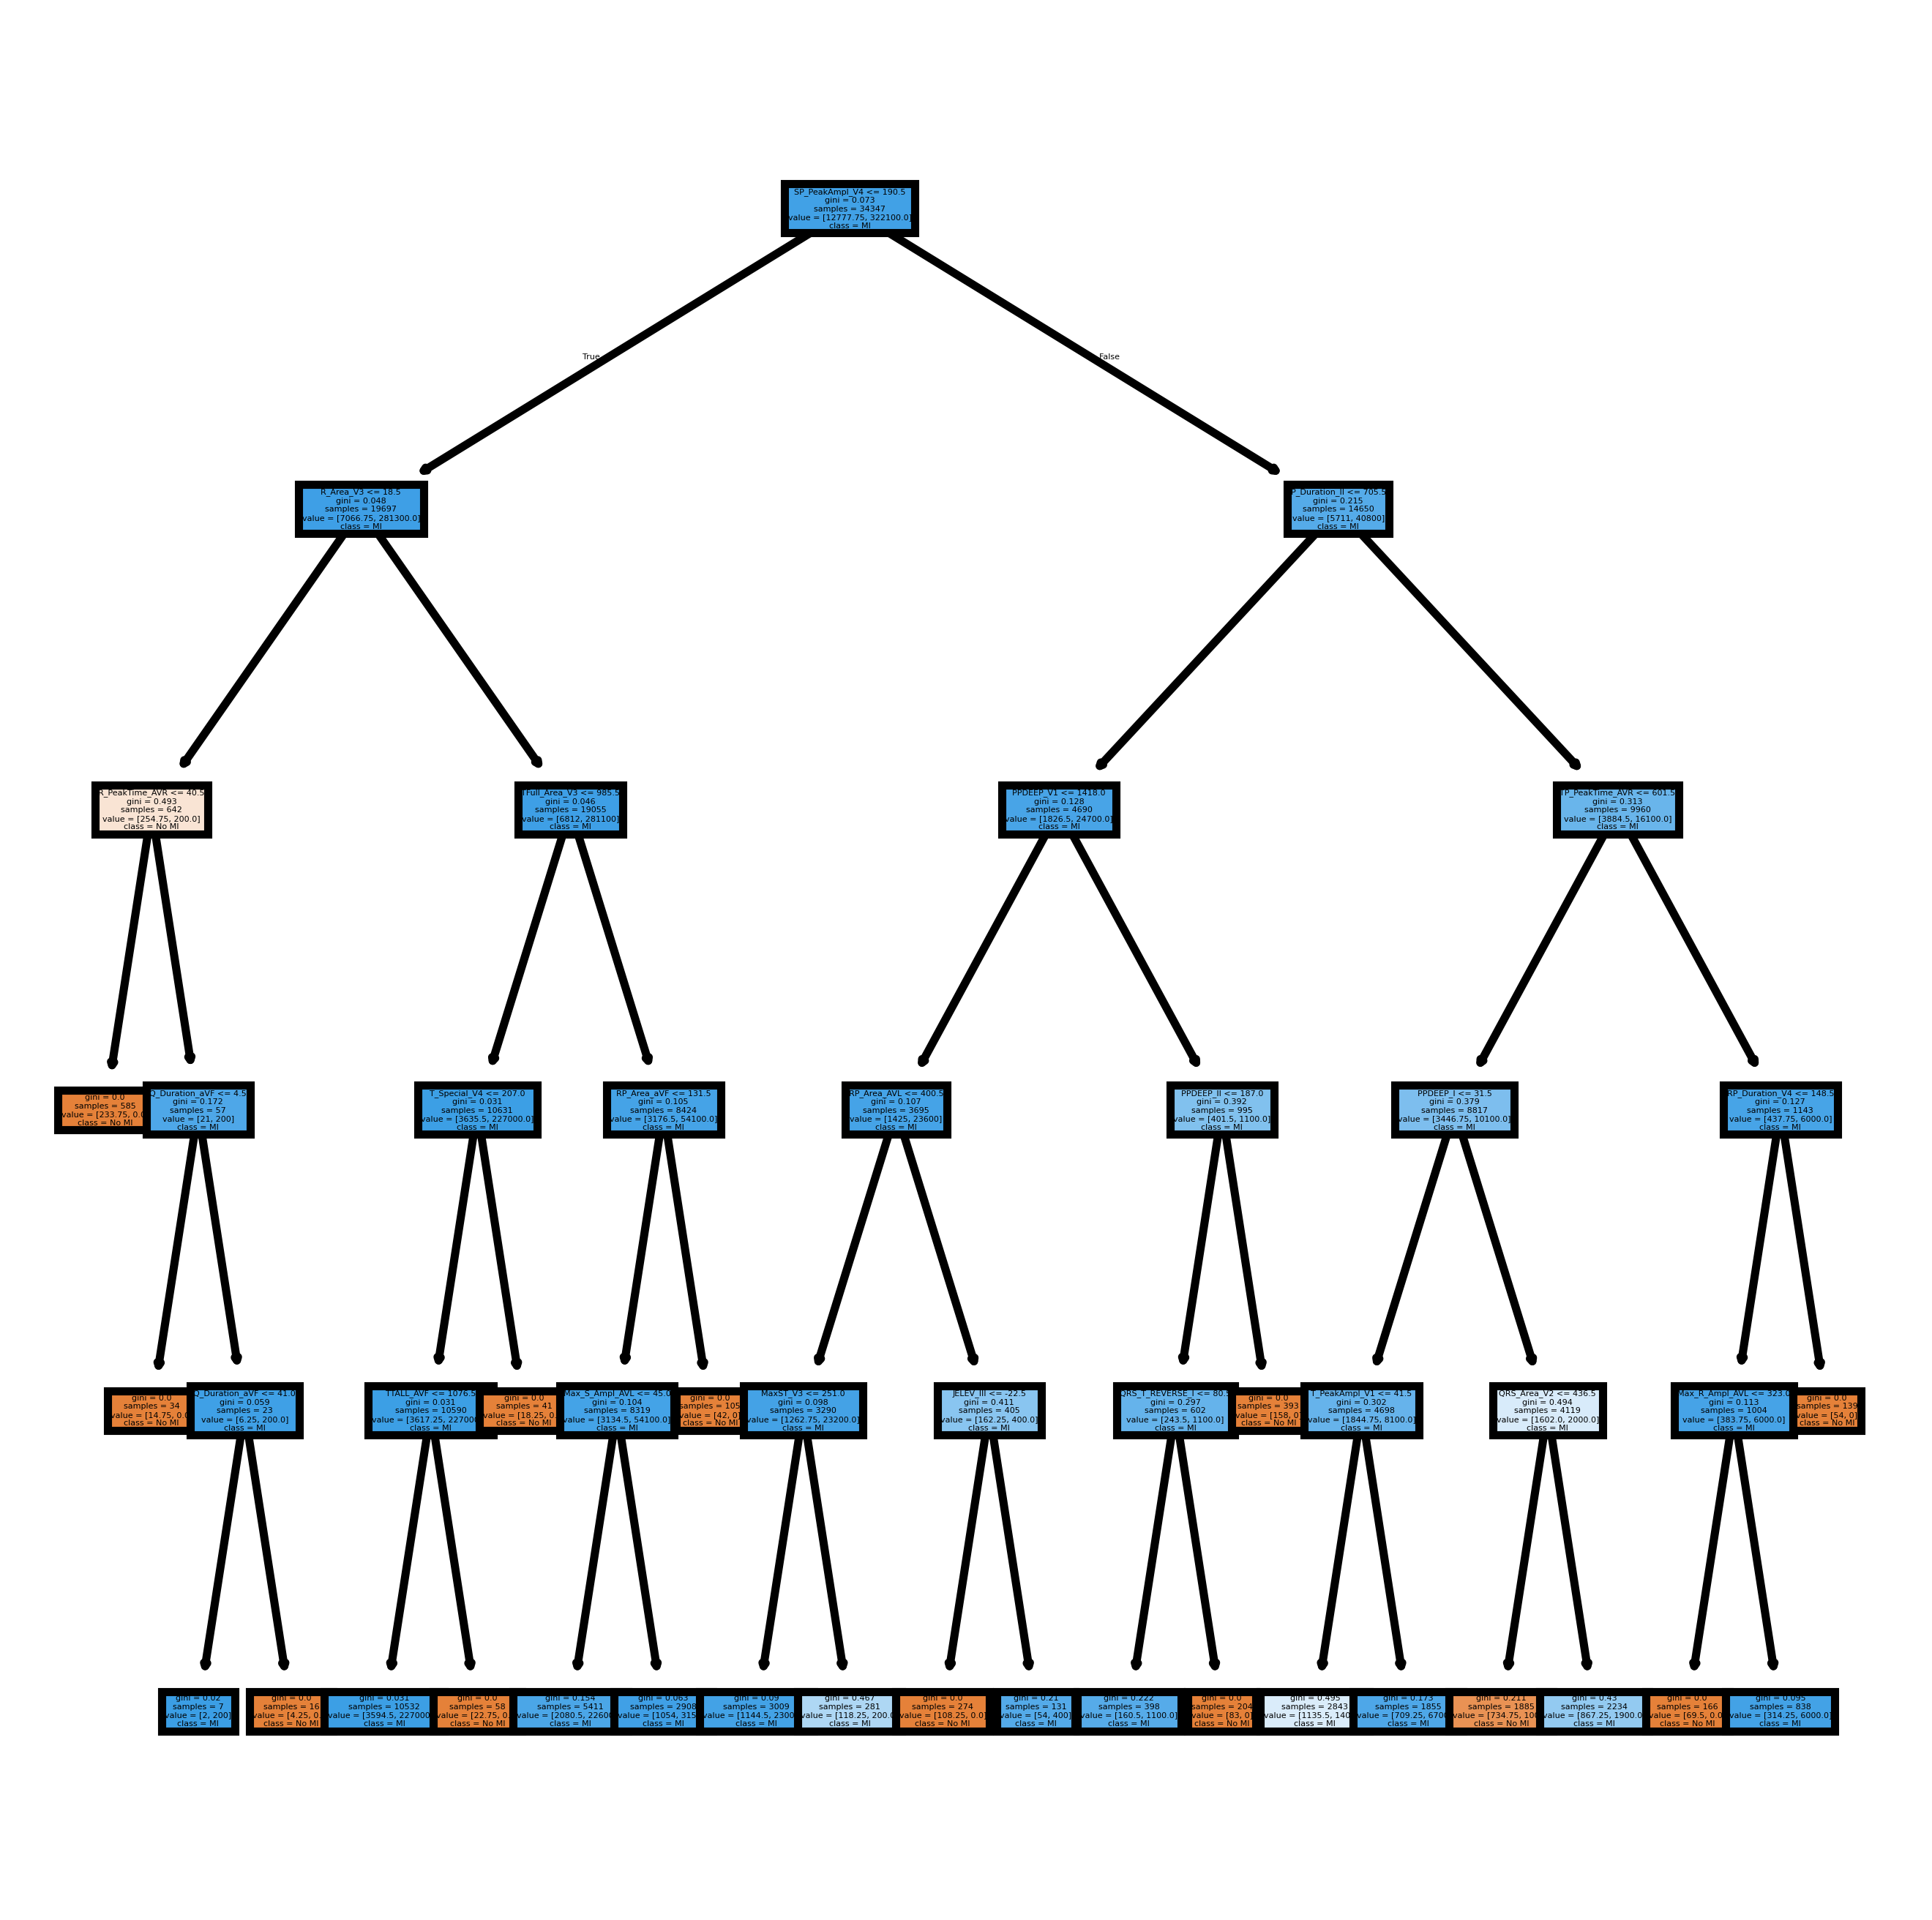

In [7]:
#branch extraction for negative samples
from sklearn import tree

fn=df.columns.tolist()
cn=['No MI', 'MI']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf_neg.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True)
fig.savefig('rf_individualtree.png')